## LANDMARK CLASSIFICATION WITH RESNET50 (CONVOLUTIONAL NEURAL NETWORKS)

Following cell is to reload libraries without restarting and plotting in notebook

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Drive folder is imported since the project is implemented on Google Colab.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Reading Dataset and Preparing Training Materials

Raw images are read through folders and resized in order to have a proper input shape for ResNet50 

In [ ]:
import os
import cv2
import numpy as np

ROOT_DIR = os.path.join('/content/drive/My Drive/', 'Landmark_Classification/')
LOG_DIR  = os.path.join(ROOT_DIR, 'logs/')
MODEL_DIR = os.path.join(ROOT_DIR, 'models/')
DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset/')
TRAIN_DIR   = os.path.join(DATASET_DIR, 'training/')
VAL_DIR   = os.path.join(DATASET_DIR, 'validation/')


train_count = len(os.listdir(TRAIN_DIR))
val_count = len(os.listdir(VAL_DIR))
  
train_x, train_y = np.zeros((train_count,224,224,3)), np.zeros((train_count))
val_x, val_y = np.zeros((val_count,224,224,3)), np.zeros((val_count))

for img_ind, train_img in enumerate(os.listdir(TRAIN_DIR)):
    img = cv2.imread(os.path.join(TRAIN_DIR, train_img))
    resized_img = cv2.resize(img, (224,224))
    class_ind = int(train_img.split('-')[0])
    train_x[img_ind] = resized_img
    train_y[img_ind] = class_ind
    
for img_ind, val_img in enumerate(os.listdir(VAL_DIR)):
    img = cv2.imread(os.path.join(VAL_DIR, val_img))
    resized_img = cv2.resize(img, (224,224))
    class_ind = int(val_img.split('-')[0])
    val_x[img_ind] = resized_img
    val_y[img_ind] = class_ind

    
class_dict = {0: 'Galata Tower', 1: 'Hagia Sophia', 2: 'Maiden\'s Tower', 3: 'Ortakoy Mosque', 4: 'Valens Aqueduct'}

### Calling ResNet50 model with imagenet pre-trained weights.

In [4]:
import keras

from keras.layers    import Dense,Flatten, GlobalAveragePooling2D
from keras           import Model
from keras.models    import Sequential, load_model
from keras.utils     import np_utils
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard

from keras.applications.resnet50 import ResNet50
from keras.optimizers            import Adam, SGD
from keras.preprocessing.image   import ImageDataGenerator

initial_model = ResNet50(include_top=False, weights='imagenet')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


To add 'head layers' in order to classify landmarks

In [ ]:
last = initial_model.output
x = GlobalAveragePooling2D()(last)
# x = Dense(1024, activation='relu', name='Dense-1')(x)
preds = Dense(5, activation='softmax', name='Dense-2')(x)

model = Model(initial_model.input, preds)

Freezing imagenet weights for training only head layers

In [ ]:
for layer in model.layers[:-2]:
    layer.trainable=False

Fitting network with landmark training materials

In [7]:
optimizer = SGD(lr=8e-3)
bs = 16
weights = {0: len(np.where(train_y==0)), 1: 1/len(np.where(train_y==1)), 2: 1/len(np.where(train_y==2)), 3: 1/len(np.where(train_y==3)), 4: 1/len(np.where(train_y==4))}

model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])


lr_reduce  = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
checkpoint = keras.callbacks.ModelCheckpoint(MODEL_DIR + 'modelfile', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
train_Y = np_utils.to_categorical(train_y, 5)
val_Y = np_utils.to_categorical(val_y, 5)

history = model.fit(train_x, train_Y, batch_size=bs, validation_data=(val_x, val_Y), epochs=15, callbacks=[lr_reduce,checkpoint], class_weight=weights)


# datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True)

# datagen.fit(train_x)

# # fits the model on batches with real-time data augmentation:
# model.fit_generator(datagen.flow(train_x, train_Y, batch_size=16),
#                     steps_per_epoch=len(train_x) / 16, epochs=25, validation_data=(val_x, val_Y))


Instructions for updating:
Use tf.cast instead.
Train on 1195 samples, validate on 289 samples
Epoch 1/15
1195/1195 [==============================] - 17s 14ms/step - loss: 0.8206 - acc: 0.7255 - val_loss: 0.5717 - val_acc: 0.8062

Epoch 00001: val_acc improved from -inf to 0.80623, saving model to /content/drive/My Drive/Landmark_Classification/models/modelfile
Epoch 2/15
1195/1195 [==============================] - 13s 11ms/step - loss: 0.3926 - acc: 0.9038 - val_loss: 0.4006 - val_acc: 0.8824

Epoch 00002: val_acc improved from 0.80623 to 0.88235, saving model to /content/drive/My Drive/Landmark_Classification/models/modelfile
Epoch 3/15
1195/1195 [==============================] - 13s 11ms/step - loss: 0.2945 - acc: 0.9205 - val_loss: 0.4890 - val_acc: 0.8304

Epoch 00003: val_acc did not improve from 0.88235
Epoch 4/15
1195/1195 [==============================] - 13s 11ms/step - loss: 0.2415 - acc: 0.9414 - val_loss: 0.3642 - val_acc: 0.8685

Epoch 00004: val_acc did not improve f

### Performance Evaluation

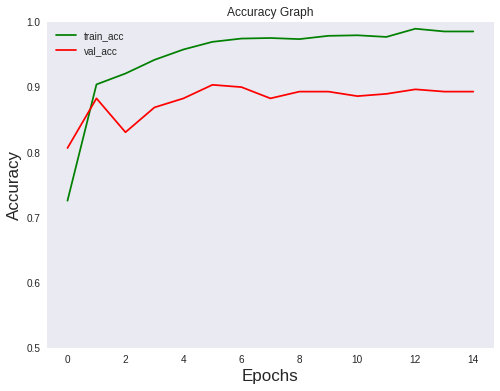

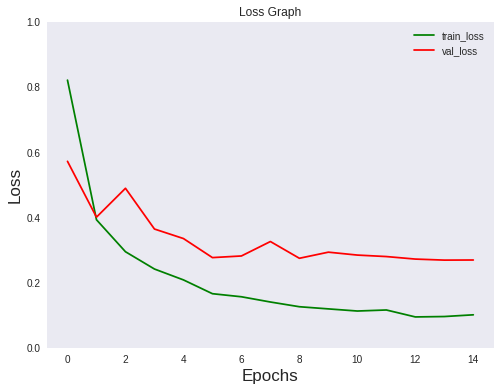

True

In [11]:
from utils import get_conf_matrix, visualize_conf_matrix, visualize_wrong_preds, visualize_history

visualize_history(history)

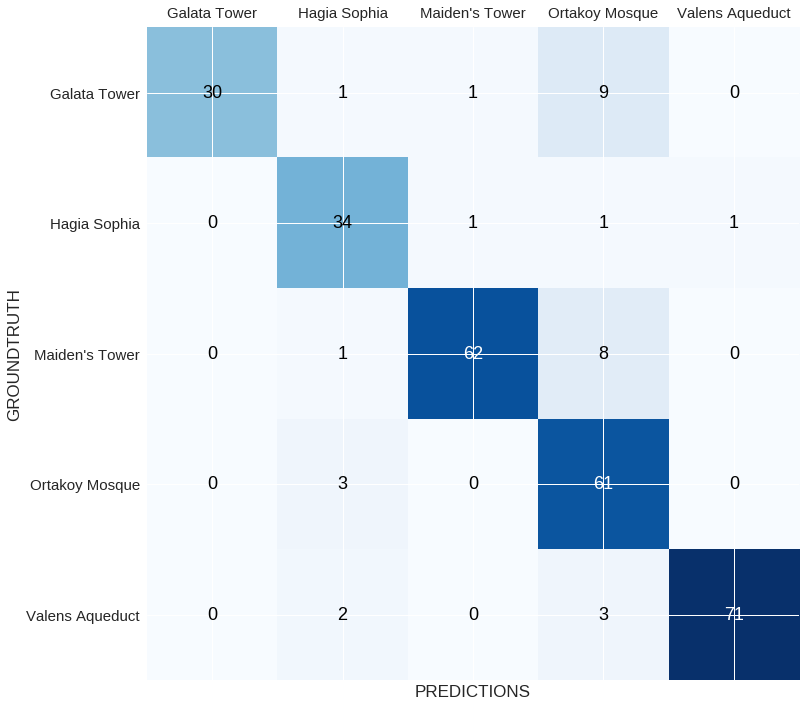

True

In [12]:
cm, preds, wrong_preds = get_conf_matrix(model, (val_x, val_y))
visualize_conf_matrix(cm, class_dict)

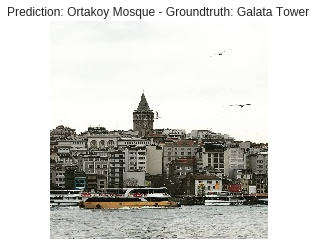

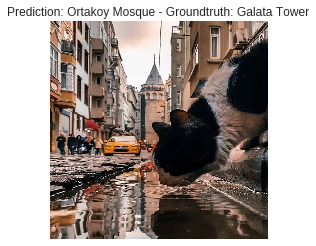

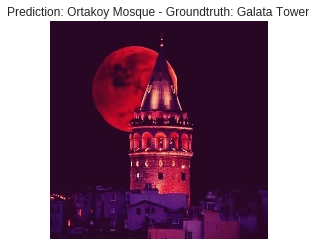

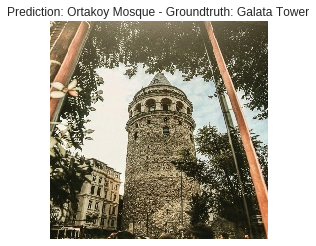

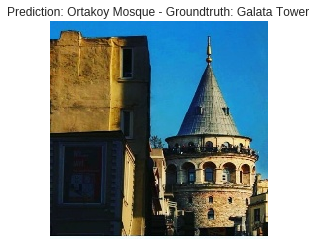

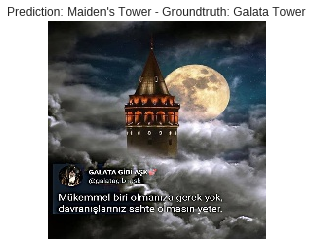

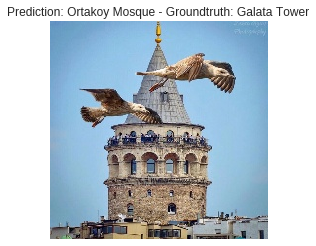

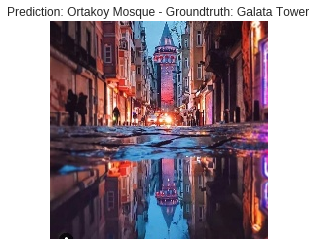

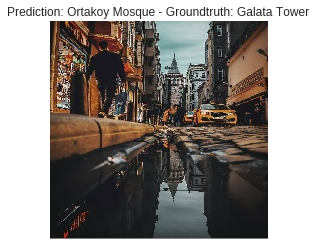

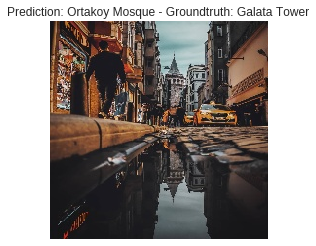

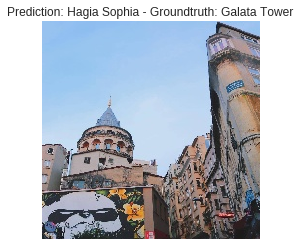

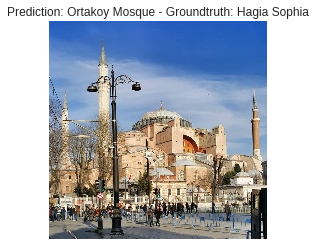

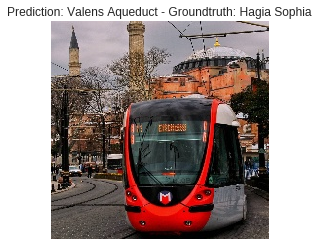

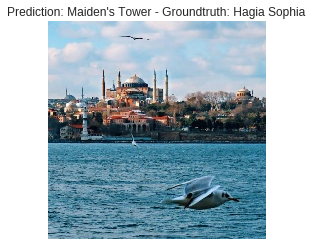

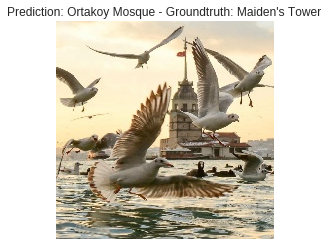

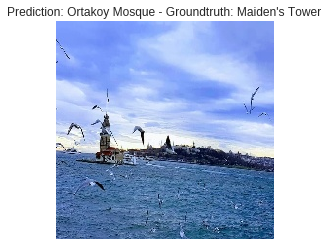

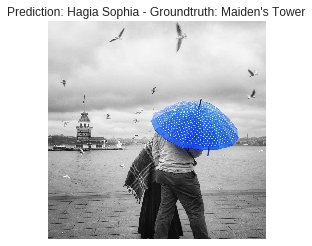

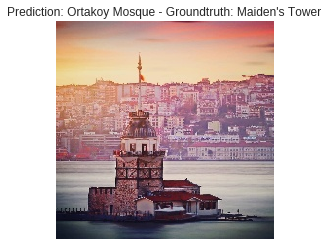

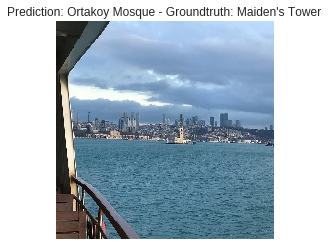

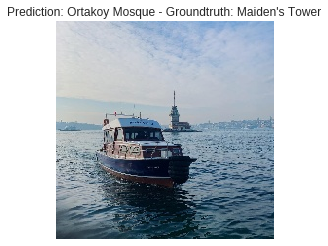

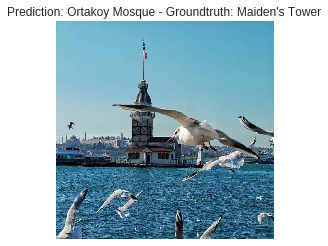

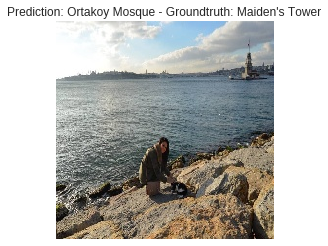

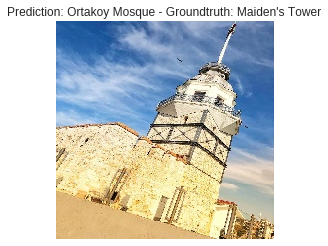

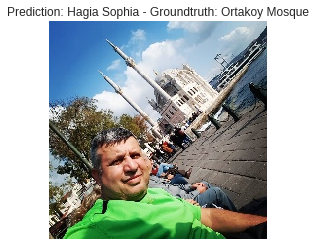

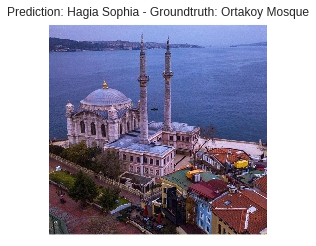

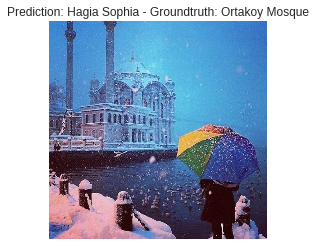

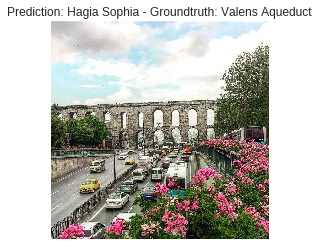

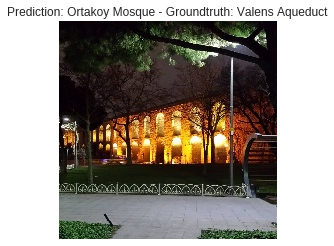

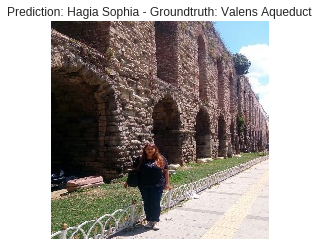

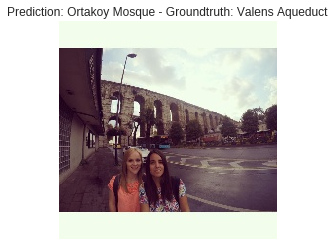

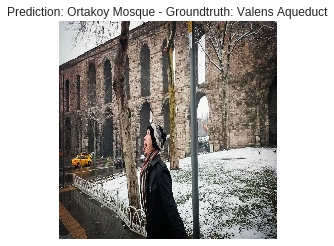

True

In [13]:
visualize_wrong_preds(wrong_preds, (val_x, val_y), preds, class_dict)

### Fine-tuning

In [ ]:
pretrained_model = load_model(MODEL_DIR + 'modelfile')

for layer in pretrained_model.layers:
    layer.trainable=True

optimizer = SGD(lr=8e-6)
bs = 16
weights = {0: len(np.where(train_y==0)), 1: 1/len(np.where(train_y==1)), 2: 1/len(np.where(train_y==2)), 3: 1/len(np.where(train_y==3)), 4: 1/len(np.where(train_y==4))}


In [15]:
pretrained_model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])

lr_reduce  = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
checkpoint = keras.callbacks.ModelCheckpoint(MODEL_DIR + 'modelfile_pretrained', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history_pretrained = pretrained_model.fit(train_x, train_Y, batch_size=bs, validation_data=(val_x, val_Y), epochs=5, callbacks=[lr_reduce,checkpoint], class_weight=weights)


Train on 1195 samples, validate on 289 samples
Epoch 1/5
1195/1195 [==============================] - 47s 39ms/step - loss: 0.1613 - acc: 0.9674 - val_loss: 0.2072 - val_acc: 0.9412

Epoch 00001: val_acc improved from -inf to 0.94118, saving model to /content/drive/My Drive/Landmark_Classification/models/modelfile_pretrained
Epoch 2/5
1195/1195 [==============================] - 38s 32ms/step - loss: 0.1681 - acc: 0.9590 - val_loss: 0.2067 - val_acc: 0.9412

Epoch 00002: val_acc did not improve from 0.94118
Epoch 3/5
1195/1195 [==============================] - 38s 32ms/step - loss: 0.1715 - acc: 0.9607 - val_loss: 0.2052 - val_acc: 0.9412

Epoch 00003: val_acc did not improve from 0.94118
Epoch 4/5
1195/1195 [==============================] - 38s 32ms/step - loss: 0.1692 - acc: 0.9623 - val_loss: 0.2050 - val_acc: 0.9412

Epoch 00004: val_acc did not improve from 0.94118
Epoch 5/5
1195/1195 [==============================] - 38s 32ms/step - loss: 0.1699 - acc: 0.9615 - val_loss: 0.204

### Performance Evaluation

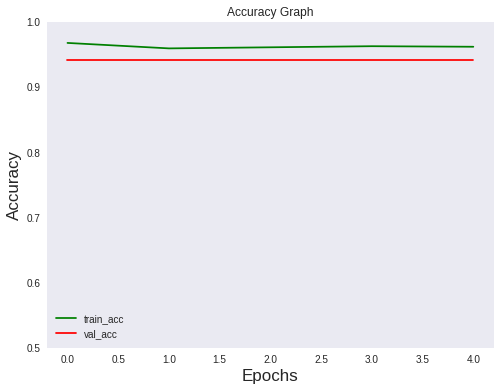

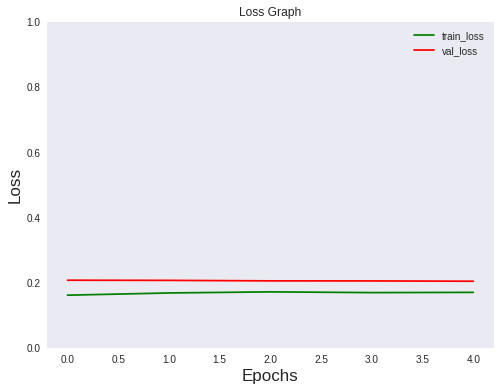

True

In [16]:
from utils import get_conf_matrix, visualize_conf_matrix, visualize_wrong_preds
visualize_history(history_pretrained)

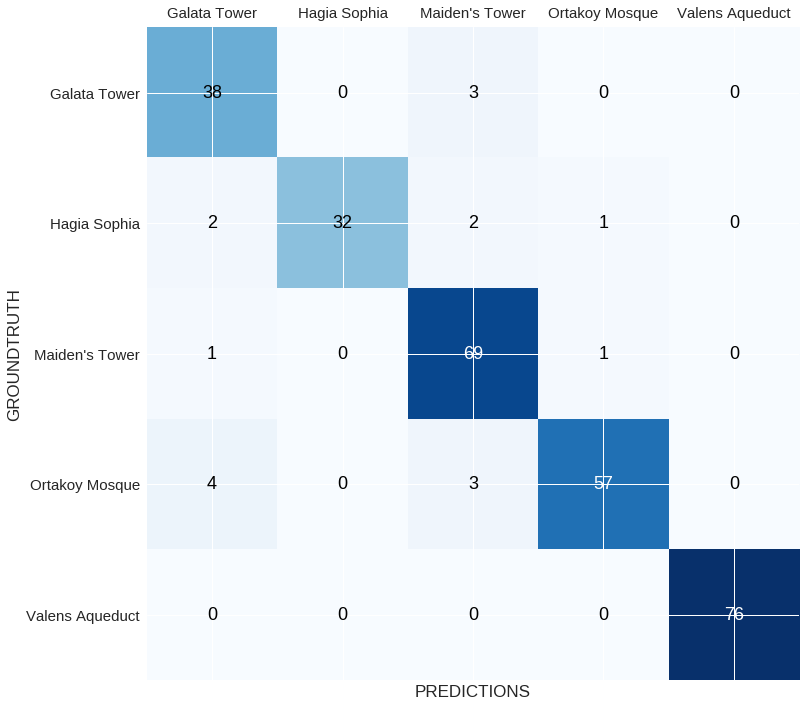

True

In [17]:
cm_pr, preds_pr, wrong_preds_pr = get_conf_matrix(pretrained_model, (val_x, val_y))
visualize_conf_matrix(cm_pr, class_dict)

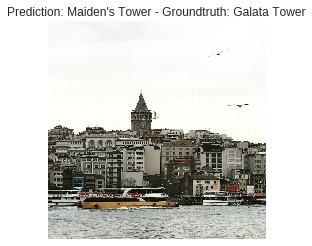

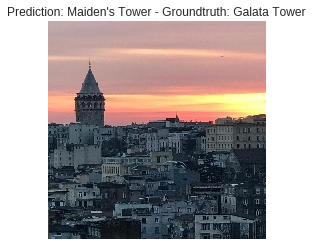

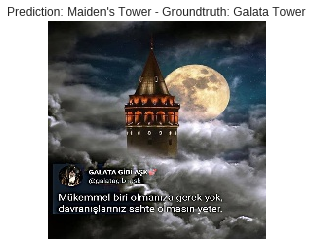

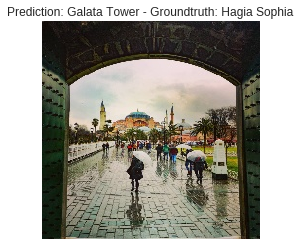

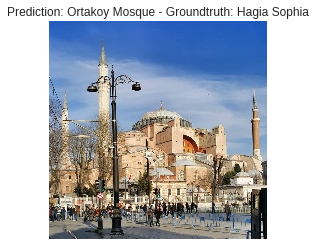

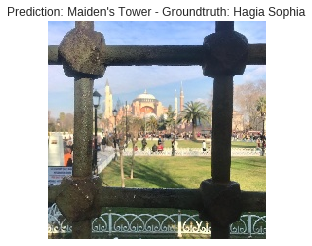

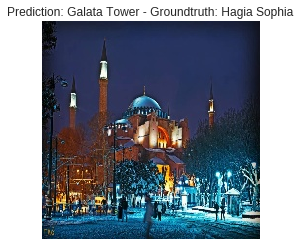

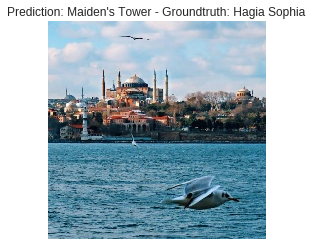

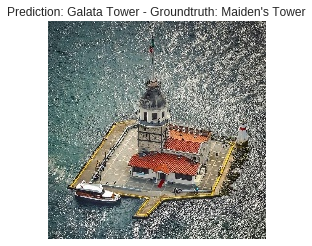

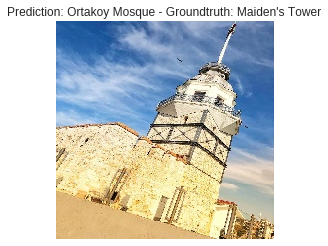

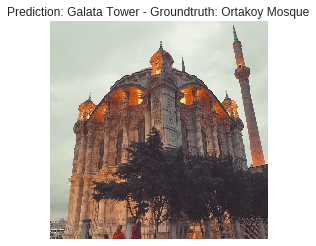

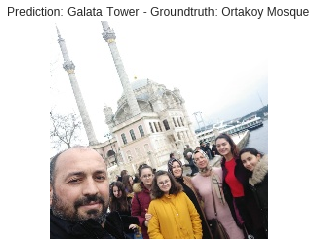

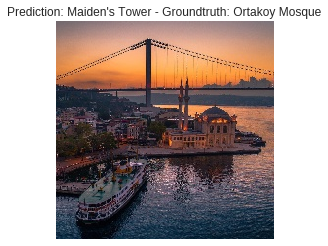

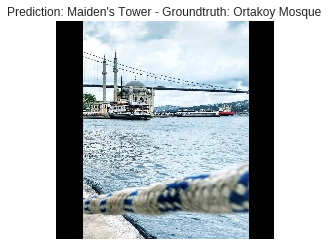

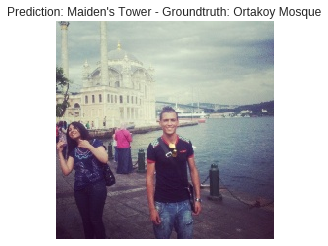

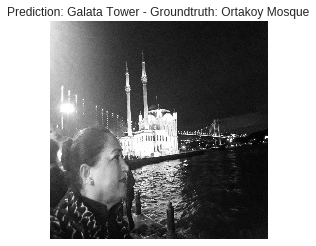

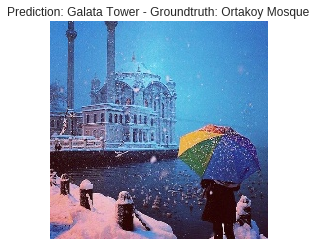

True

In [18]:
visualize_wrong_preds(wrong_preds_pr, (val_x, val_y), preds_pr, class_dict)